# DeepLog HDFS Anomaly Detection - Results Analysis

**Paper**: Min Du et al., "DeepLog: Anomaly Detection and Diagnosis from System Logs through Deep Learning", CCS 2017

This notebook visualizes the reproduction results and compares them against the original paper's reported metrics.

In [1]:
import sys, os
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import torch
from collections import Counter, defaultdict

# Project paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

# Style
plt.rcParams.update({
    'figure.figsize': (12, 5),
    'figure.dpi': 120,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
})

COLORS = {
    'train': '#2196F3',
    'val': '#FF9800',
    'paper': '#4CAF50',
    'ours': '#E91E63',
    'tp': '#4CAF50',
    'tn': '#2196F3',
    'fp': '#FF9800',
    'fn': '#F44336',
    'normal': '#2196F3',
    'anomaly': '#F44336',
}

print(f'Project root: {PROJECT_ROOT}')

Project root: /home/beethoven/laboratory/machine-learning/deeplearning/unsupervised-learning/lstm/anomaly-detection/2026-02-06


In [2]:
# Load all data
with open(os.path.join(PROJECT_ROOT, 'results', 'metrics.json')) as f:
    metrics = json.load(f)

ckpt = torch.load(
    os.path.join(PROJECT_ROOT, 'checkpoints', 'best_model.pth'),
    map_location='cpu'
)
train_losses = ckpt['train_losses']
val_losses = ckpt['val_losses']
best_epoch = ckpt['epoch']

with open(os.path.join(PROJECT_ROOT, 'data', 'processed', 'train_sequences.pkl'), 'rb') as f:
    train_data = pickle.load(f)

with open(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_sequences.pkl'), 'rb') as f:
    test_data = pickle.load(f)

# Paper targets
paper = {
    'fp': 833, 'fn': 619,
    'precision': 0.951, 'recall': 0.964, 'f1': 0.96,
    'train_sessions': 4855,
    'test_normal': 553366, 'test_abnormal': 16838,
}

print('Data loaded successfully.')
print(f'Training sequences: {len(train_data["sequences"]):,}')
print(f'Test sequences:     {len(test_data["sequences"]):,}')
print(f'Best epoch:         {best_epoch}')

Data loaded successfully.
Training sequences: 78,093
Test sequences:     5,389,938
Best epoch:         33


---
## 1. Training Curves

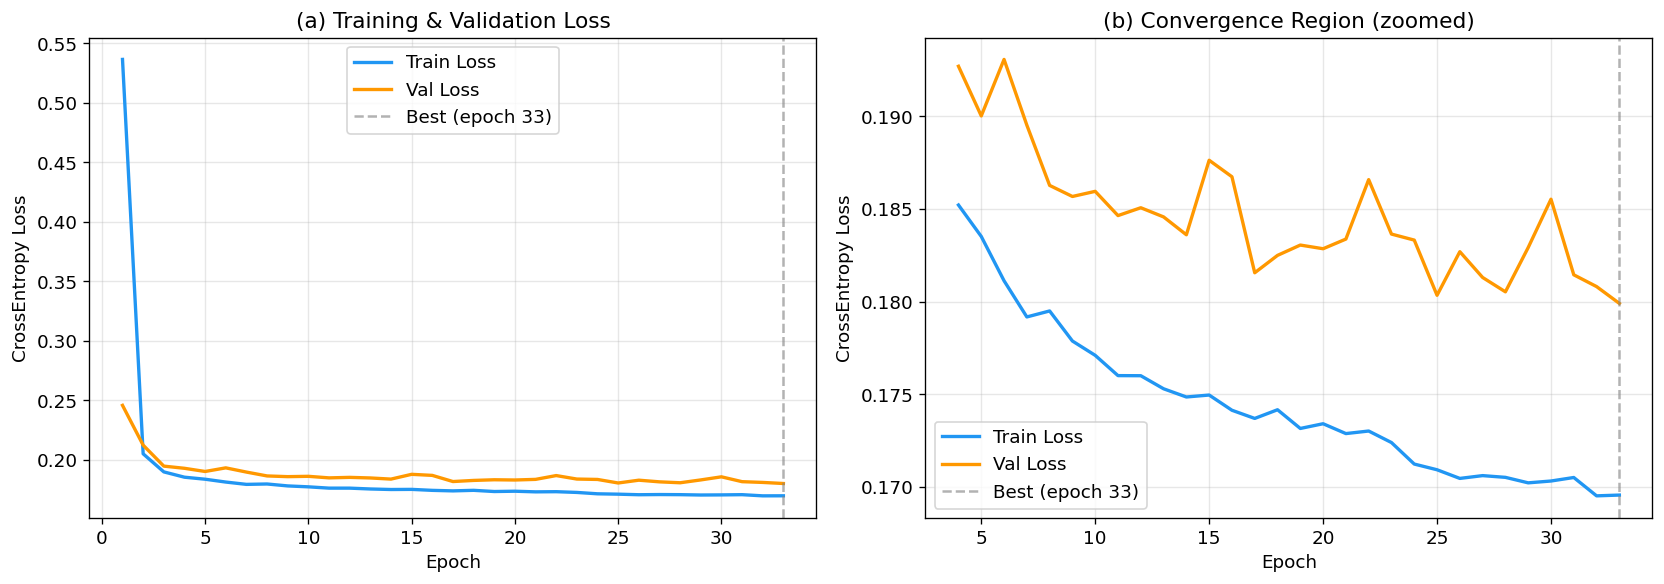

Best validation loss: 0.1799 at epoch 33
Final train loss:     0.1696
Train-val gap:        0.0103


In [3]:
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Full training curve
ax = axes[0]
ax.plot(epochs, train_losses, color=COLORS['train'], linewidth=2, label='Train Loss')
ax.plot(epochs, val_losses, color=COLORS['val'], linewidth=2, label='Val Loss')
ax.axvline(best_epoch, color='gray', linestyle='--', alpha=0.6, label=f'Best (epoch {best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('CrossEntropy Loss')
ax.set_title('(a) Training & Validation Loss')
ax.legend()

# (b) Zoomed into convergence region
ax = axes[1]
start = 3  # skip first few noisy epochs
ax.plot(epochs[start:], train_losses[start:], color=COLORS['train'], linewidth=2, label='Train Loss')
ax.plot(epochs[start:], val_losses[start:], color=COLORS['val'], linewidth=2, label='Val Loss')
ax.axvline(best_epoch, color='gray', linestyle='--', alpha=0.6, label=f'Best (epoch {best_epoch})')
ax.set_xlabel('Epoch')
ax.set_ylabel('CrossEntropy Loss')
ax.set_title('(b) Convergence Region (zoomed)')
ax.legend()

fig.tight_layout()
plt.show()

print(f'Best validation loss: {min(val_losses):.4f} at epoch {best_epoch}')
print(f'Final train loss:     {train_losses[-1]:.4f}')
print(f'Train-val gap:        {val_losses[-1] - train_losses[-1]:.4f}')

---
## 2. Paper vs Reproduction - Metrics Comparison

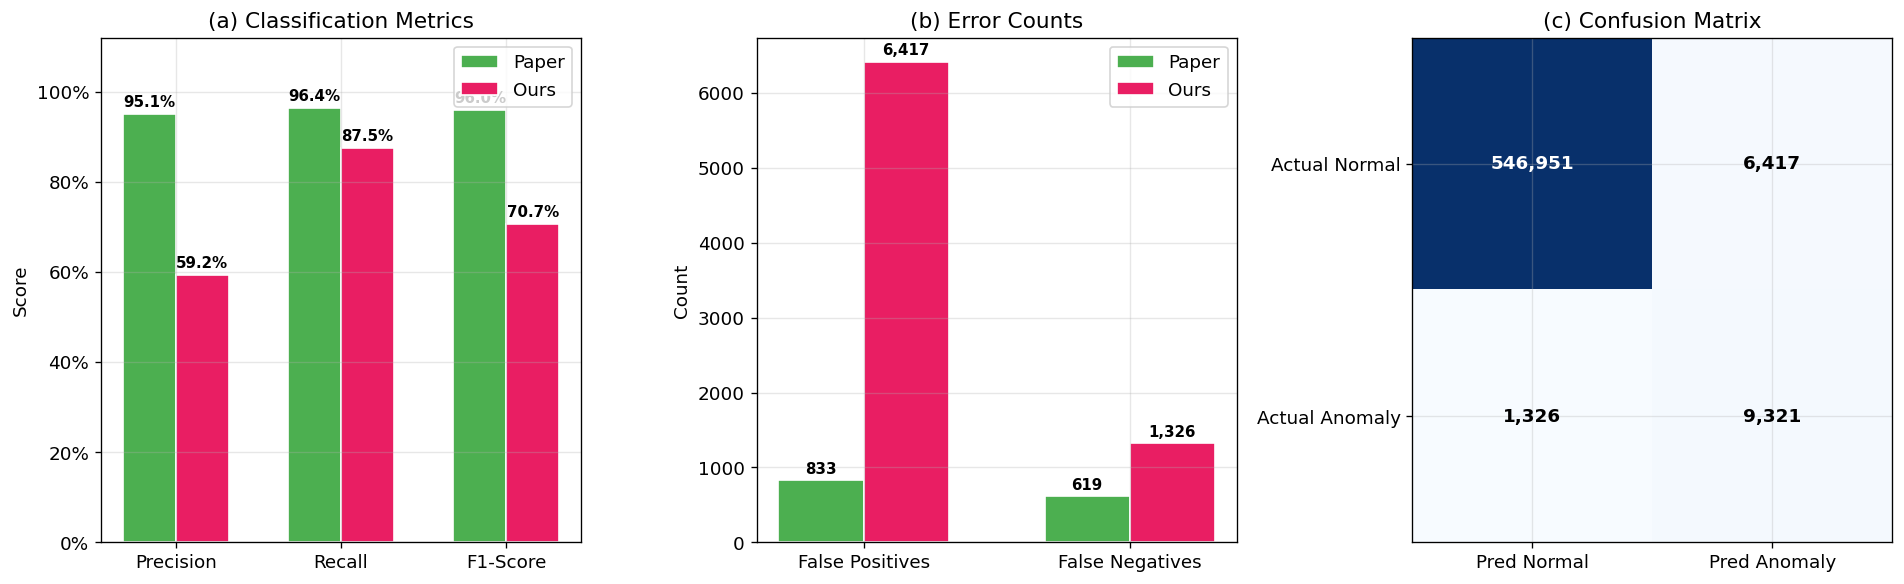

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# (a) Precision / Recall / F1
ax = axes[0]
metric_names = ['Precision', 'Recall', 'F1-Score']
paper_vals = [paper['precision'], paper['recall'], paper['f1']]
ours_vals = [metrics['precision'], metrics['recall'], metrics['f1_score']]

x = np.arange(len(metric_names))
w = 0.32
bars1 = ax.bar(x - w/2, paper_vals, w, label='Paper', color=COLORS['paper'], edgecolor='white')
bars2 = ax.bar(x + w/2, ours_vals, w, label='Ours', color=COLORS['ours'], edgecolor='white')

for bar, val in zip(bars1, paper_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, ours_vals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_ylim(0, 1.12)
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.set_ylabel('Score')
ax.set_title('(a) Classification Metrics')
ax.legend()
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# (b) FP / FN counts
ax = axes[1]
count_names = ['False Positives', 'False Negatives']
paper_counts = [paper['fp'], paper['fn']]
ours_counts = [metrics['false_positives'], metrics['false_negatives']]

x = np.arange(len(count_names))
bars1 = ax.bar(x - w/2, paper_counts, w, label='Paper', color=COLORS['paper'], edgecolor='white')
bars2 = ax.bar(x + w/2, ours_counts, w, label='Ours', color=COLORS['ours'], edgecolor='white')

for bar, val in zip(bars1, paper_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar, val in zip(bars2, ours_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{val:,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(count_names)
ax.set_ylabel('Count')
ax.set_title('(b) Error Counts')
ax.legend()

# (c) Confusion matrix heatmap
ax = axes[2]
cm = np.array([
    [metrics['true_negatives'], metrics['false_positives']],
    [metrics['false_negatives'], metrics['true_positives']]
])
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred Normal', 'Pred Anomaly'])
ax.set_yticklabels(['Actual Normal', 'Actual Anomaly'])
ax.set_title('(c) Confusion Matrix')

for i in range(2):
    for j in range(2):
        color = 'white' if cm[i, j] > cm.max() * 0.5 else 'black'
        ax.text(j, i, f'{cm[i, j]:,}', ha='center', va='center',
                fontsize=11, fontweight='bold', color=color)

fig.tight_layout()
plt.show()

---
## 3. Data Split Verification

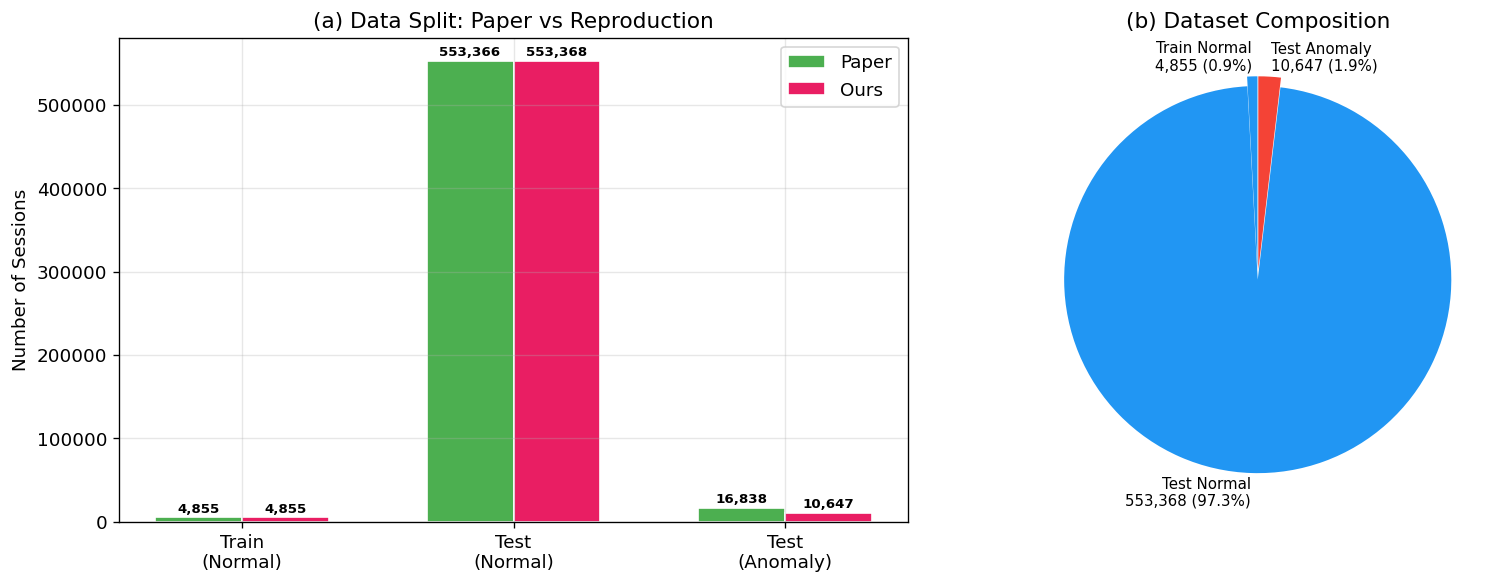


--- Data Split Summary ---
                          Paper       Ours     Diff
--------------------------------------------------
Train (Normal)            4,855      4,855       +0
Test (Normal)           553,366    553,368       +2
Test (Anomaly)           16,838     10,647   -6,191


In [5]:
train_sessions = len(set(train_data['block_ids']))
test_block_ids = test_data['block_ids']
test_session_labels = test_data['session_labels']

# Count test sessions by label
test_session_map = {}
for bid, label in zip(test_block_ids, test_session_labels):
    test_session_map[bid] = label
test_normal = sum(1 for v in test_session_map.values() if v == 'Normal')
test_anomaly = sum(1 for v in test_session_map.values() if v == 'Anomaly')

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Session split comparison
ax = axes[0]
categories = ['Train\n(Normal)', 'Test\n(Normal)', 'Test\n(Anomaly)']
paper_split = [paper['train_sessions'], paper['test_normal'], paper['test_abnormal']]
ours_split = [train_sessions, test_normal, test_anomaly]

x = np.arange(len(categories))
bars1 = ax.bar(x - w/2, paper_split, w, label='Paper', color=COLORS['paper'], edgecolor='white')
bars2 = ax.bar(x + w/2, ours_split, w, label='Ours', color=COLORS['ours'], edgecolor='white')

for bar, val in zip(bars1, paper_split):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
            f'{val:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')
for bar, val in zip(bars2, ours_split):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2000,
            f'{val:,}', ha='center', va='bottom', fontsize=8, fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel('Number of Sessions')
ax.set_title('(a) Data Split: Paper vs Reproduction')
ax.legend()

# (b) Train/test proportion pie
ax = axes[1]
total = train_sessions + test_normal + test_anomaly
sizes = [train_sessions, test_normal, test_anomaly]
labels_pie = [
    f'Train Normal\n{train_sessions:,} ({train_sessions/total:.1%})',
    f'Test Normal\n{test_normal:,} ({test_normal/total:.1%})',
    f'Test Anomaly\n{test_anomaly:,} ({test_anomaly/total:.1%})'
]
colors_pie = [COLORS['train'], COLORS['normal'], COLORS['anomaly']]
explode = (0.05, 0, 0.05)
ax.pie(sizes, labels=labels_pie, colors=colors_pie, explode=explode,
       autopct='', startangle=90, textprops={'fontsize': 9})
ax.set_title('(b) Dataset Composition')

fig.tight_layout()
plt.show()

# Summary table
print('\n--- Data Split Summary ---')
print(f'{"":<20s} {"Paper":>10s} {"Ours":>10s} {"Diff":>8s}')
print('-' * 50)
for name, p, o in [
    ('Train (Normal)', paper['train_sessions'], train_sessions),
    ('Test (Normal)', paper['test_normal'], test_normal),
    ('Test (Anomaly)', paper['test_abnormal'], test_anomaly),
]:
    print(f'{name:<20s} {p:>10,} {o:>10,} {o - p:>+8,}')

---
## 4. Log Key Distribution Analysis

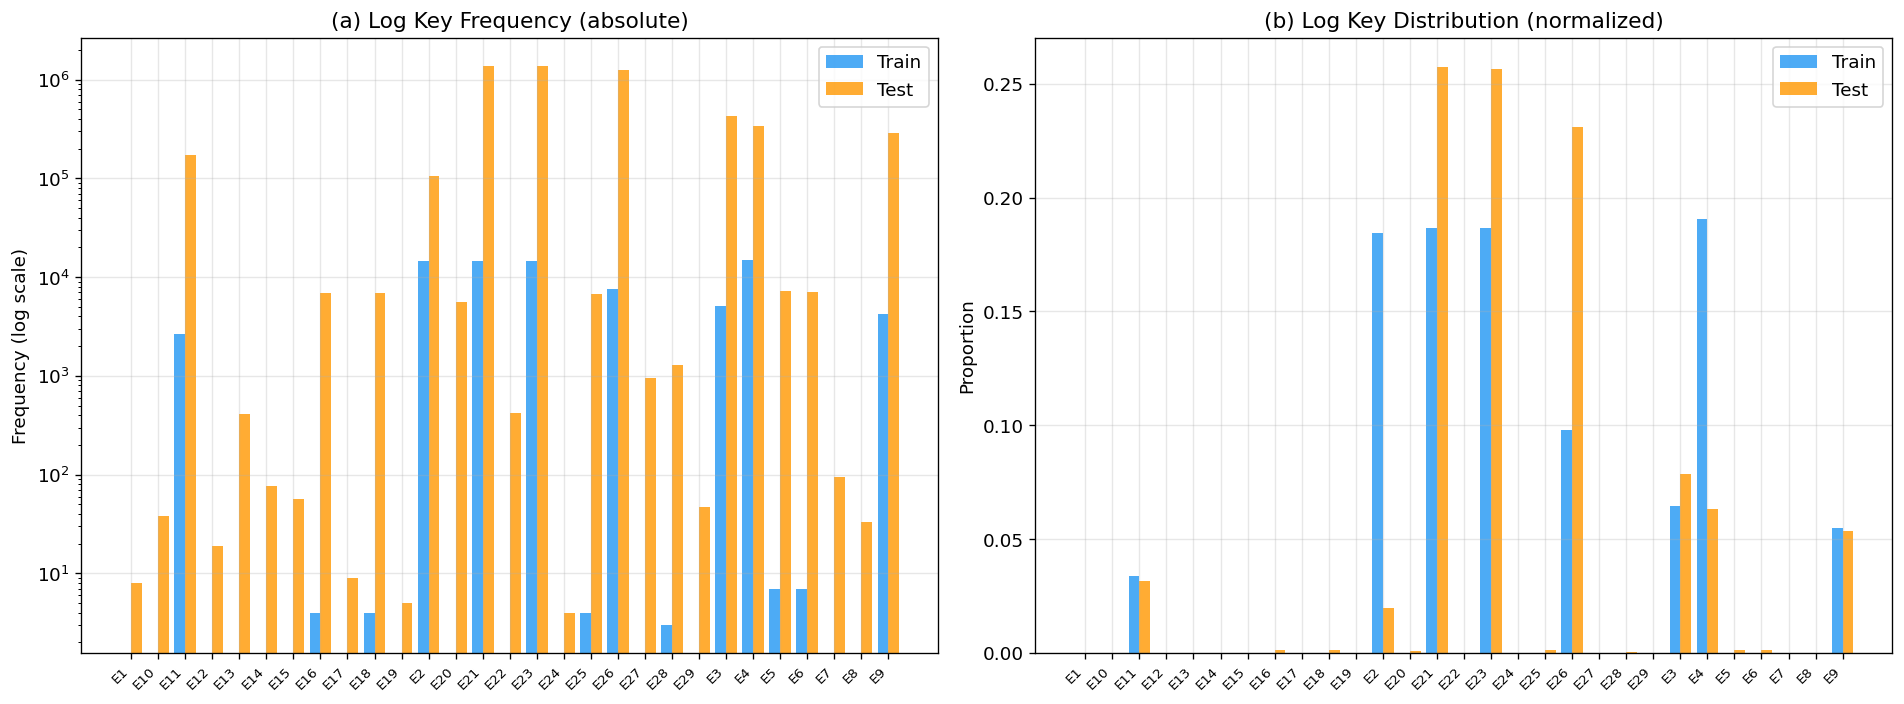


Top 5 keys with largest train-test distribution gap:
    E2: train=0.1845, test=0.0196, diff=0.1649
   E26: train=0.0982, test=0.2312, diff=0.1331
    E4: train=0.1906, test=0.0633, diff=0.1273
   E21: train=0.1866, test=0.2574, diff=0.0708
   E23: train=0.1866, test=0.2563, diff=0.0697


In [6]:
idx_to_key = train_data['idx_to_log_key']

# Count log key frequencies from training labels (next tokens)
train_labels = [seq[1] for seq in train_data['sequences']]
test_labels = [seq[1] for seq in test_data['sequences']]

train_counter = Counter(train_labels)
test_counter = Counter(test_labels)

all_keys = sorted(idx_to_key.keys())
key_names = [idx_to_key[k] for k in all_keys]

train_freq = np.array([train_counter.get(k, 0) for k in all_keys], dtype=float)
test_freq = np.array([test_counter.get(k, 0) for k in all_keys], dtype=float)
train_freq_norm = train_freq / train_freq.sum()
test_freq_norm = test_freq / test_freq.sum()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (a) Absolute frequency
ax = axes[0]
x = np.arange(len(key_names))
ax.bar(x - 0.2, train_freq, 0.4, label='Train', color=COLORS['train'], alpha=0.8)
ax.bar(x + 0.2, test_freq, 0.4, label='Test', color=COLORS['val'], alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(key_names, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Frequency (log scale)')
ax.set_yscale('log')
ax.set_title('(a) Log Key Frequency (absolute)')
ax.legend()

# (b) Normalized distribution comparison
ax = axes[1]
ax.bar(x - 0.2, train_freq_norm, 0.4, label='Train', color=COLORS['train'], alpha=0.8)
ax.bar(x + 0.2, test_freq_norm, 0.4, label='Test', color=COLORS['val'], alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(key_names, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('Proportion')
ax.set_title('(b) Log Key Distribution (normalized)')
ax.legend()

fig.tight_layout()
plt.show()

# Identify keys with biggest train/test distribution gap
diff = np.abs(train_freq_norm - test_freq_norm)
top_diff_idx = np.argsort(diff)[::-1][:5]
print('\nTop 5 keys with largest train-test distribution gap:')
for idx in top_diff_idx:
    print(f'  {key_names[idx]:>4s}: train={train_freq_norm[idx]:.4f}, '
          f'test={test_freq_norm[idx]:.4f}, diff={diff[idx]:.4f}')

---
## 5. Session-Level Error Analysis

/tmp/ipykernel_13493/2982296390.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_box, labels=['Normal', 'Anomaly'], patch_artist=True,


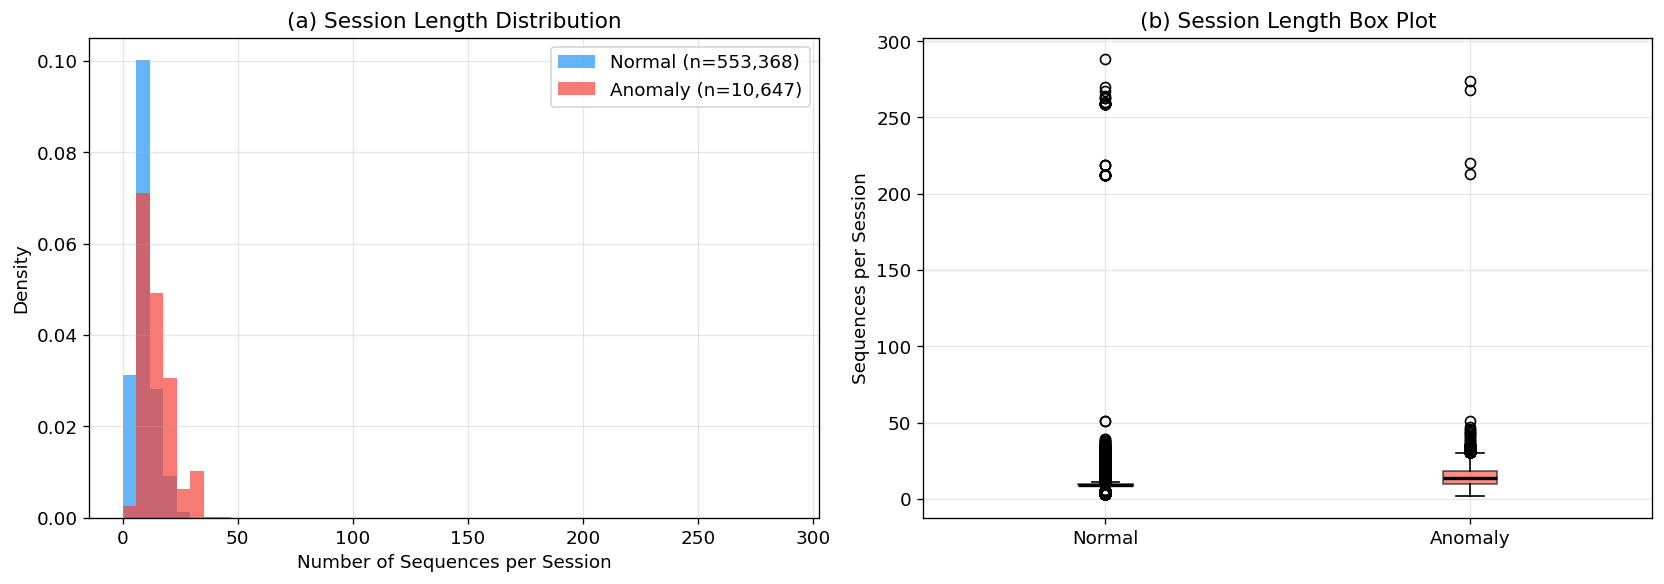

Normal sessions  - mean: 9.4, median: 9.0, max: 288
Anomaly sessions - mean: 15.3, median: 14.0, max: 274


In [7]:
# Analyze session length distribution for normal vs anomaly sessions in test set
session_lengths = defaultdict(int)
session_label_map = {}

for bid, label in zip(test_data['block_ids'], test_data['session_labels']):
    session_lengths[bid] += 1
    session_label_map[bid] = label

normal_lengths = [l for bid, l in session_lengths.items() if session_label_map[bid] == 'Normal']
anomaly_lengths = [l for bid, l in session_lengths.items() if session_label_map[bid] == 'Anomaly']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Session length distribution
ax = axes[0]
bins = np.linspace(0, max(max(normal_lengths), max(anomaly_lengths)), 50)
ax.hist(normal_lengths, bins=bins, alpha=0.7, label=f'Normal (n={len(normal_lengths):,})',
        color=COLORS['normal'], density=True)
ax.hist(anomaly_lengths, bins=bins, alpha=0.7, label=f'Anomaly (n={len(anomaly_lengths):,})',
        color=COLORS['anomaly'], density=True)
ax.set_xlabel('Number of Sequences per Session')
ax.set_ylabel('Density')
ax.set_title('(a) Session Length Distribution')
ax.legend()

# (b) Session length stats
ax = axes[1]
data_box = [normal_lengths, anomaly_lengths]
bp = ax.boxplot(data_box, labels=['Normal', 'Anomaly'], patch_artist=True,
                medianprops=dict(color='black', linewidth=2))
bp['boxes'][0].set_facecolor(COLORS['normal'])
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor(COLORS['anomaly'])
bp['boxes'][1].set_alpha(0.6)
ax.set_ylabel('Sequences per Session')
ax.set_title('(b) Session Length Box Plot')

fig.tight_layout()
plt.show()

print(f'Normal sessions  - mean: {np.mean(normal_lengths):.1f}, median: {np.median(normal_lengths):.1f}, '
      f'max: {max(normal_lengths)}')
print(f'Anomaly sessions - mean: {np.mean(anomaly_lengths):.1f}, median: {np.median(anomaly_lengths):.1f}, '
      f'max: {max(anomaly_lengths)}')

---
## 6. Top-g Sensitivity Analysis (Simulation)

In [8]:
%%time

# Run model inference to get per-sequence top-k predictions
import config
from model import create_model
from dataset import HDFSDataset
from train import load_checkpoint
from torch.utils.data import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(device=device)
model = load_checkpoint(model, os.path.join(PROJECT_ROOT, 'checkpoints', 'best_model.pth'))
model.eval()

test_dataset = HDFSDataset(os.path.join(PROJECT_ROOT, 'data', 'processed', 'test_sequences.pkl'))
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

MAX_G = 15

# Collect per-sequence rank of true label
all_ranks = []  # rank of true label in model output (0-indexed)
all_block_ids = []
all_session_labels = []

with torch.no_grad():
    seq_idx = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        logits = model(inputs)
        # Get sorted indices (descending by logit)
        sorted_indices = torch.argsort(logits, dim=1, descending=True).cpu()
        labels_cpu = labels.cpu()

        for i in range(len(labels_cpu)):
            true_label = labels_cpu[i].item()
            rank = (sorted_indices[i] == true_label).nonzero(as_tuple=True)[0].item()
            all_ranks.append(rank)
            all_block_ids.append(test_dataset.get_block_id(seq_idx))
            all_session_labels.append(test_dataset.get_session_label(seq_idx))
            seq_idx += 1

all_ranks = np.array(all_ranks)
print(f'Collected ranks for {len(all_ranks):,} sequences')
print(f'Rank distribution: mean={all_ranks.mean():.2f}, median={np.median(all_ranks):.1f}, '
      f'p95={np.percentile(all_ranks, 95):.0f}, max={all_ranks.max()}')

2026-02-07 07:06:44,381 - model - INFO - Initialized DeepLog model with:
2026-02-07 07:06:44,382 - model - INFO -   - Num classes: 29
2026-02-07 07:06:44,383 - model - INFO -   - Embedding dim: 64
2026-02-07 07:06:44,384 - model - INFO -   - Hidden size: 64
2026-02-07 07:06:44,386 - model - INFO -   - Num layers: 2
2026-02-07 07:06:44,666 - model - INFO - Model created with 70,301 trainable parameters
2026-02-07 07:06:44,667 - model - INFO - Model moved to device: cuda
2026-02-07 07:06:44,668 - train - INFO - Loading checkpoint from: /home/beethoven/laboratory/machine-learning/deeplearning/unsupervised-learning/lstm/anomaly-detection/2026-02-06/checkpoints/best_model.pth
2026-02-07 07:06:44,686 - train - INFO - Loaded checkpoint from epoch 33
2026-02-07 07:06:44,687 - train - INFO - Validation loss: 0.1799
2026-02-07 07:06:44,689 - dataset - INFO - Loading dataset from: /home/beethoven/laboratory/machine-learning/deeplearning/unsupervised-learning/lstm/anomaly-detection/2026-02-06/data

Collected ranks for 5,389,938 sequences
Rank distribution: mean=1.07, median=0.0, p95=6, max=28
CPU times: user 2min 59s, sys: 22.9 s, total: 3min 22s
Wall time: 3min 12s


In [9]:
# Sweep top-g from 1 to MAX_G
g_values = list(range(1, MAX_G + 1))
results_by_g = []

# Build session ground truth
session_gt = {}
for bid, label in zip(all_block_ids, all_session_labels):
    session_gt[bid] = (label == 'Anomaly')

for g in g_values:
    # sequence is anomaly if rank >= g
    seq_anomaly = all_ranks >= g

    # aggregate to session: session is anomaly if ANY sequence is anomaly
    session_pred = defaultdict(bool)
    for idx, is_anom in enumerate(seq_anomaly):
        bid = all_block_ids[idx]
        if is_anom:
            session_pred[bid] = True

    # Compute metrics
    tp = fp = fn = tn = 0
    for bid, gt in session_gt.items():
        pred = session_pred.get(bid, False)
        if gt and pred:
            tp += 1
        elif gt and not pred:
            fn += 1
        elif not gt and pred:
            fp += 1
        else:
            tn += 1

    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0
    results_by_g.append({'g': g, 'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
                         'precision': prec, 'recall': rec, 'f1': f1})

df_g = pd.DataFrame(results_by_g)
print(df_g[['g', 'fp', 'fn', 'precision', 'recall', 'f1']].to_string(index=False))

 g     fp   fn  precision   recall       f1
 1 452950    0   0.022966 1.000000 0.044901
 2 420908  229   0.024153 0.978492 0.047143
 3 390368  358   0.025680 0.966376 0.050031
 4 337644  543   0.029056 0.949000 0.056385
 5 279856  721   0.034253 0.932281 0.066079
 6 251114  843   0.037575 0.920823 0.072204
 7 124750 1251   0.070043 0.882502 0.129785
 8  13621 1309   0.406725 0.877055 0.555734
 9   6417 1326   0.592261 0.875458 0.706538
10   5633 1330   0.623211 0.875082 0.727976
11   4694 1343   0.664666 0.873861 0.755042
12   4372 1372   0.679637 0.871137 0.763563
13   2252 2307   0.787387 0.783319 0.785348
14    641 4063   0.911280 0.618390 0.736795
15    601 4513   0.910765 0.576125 0.705788


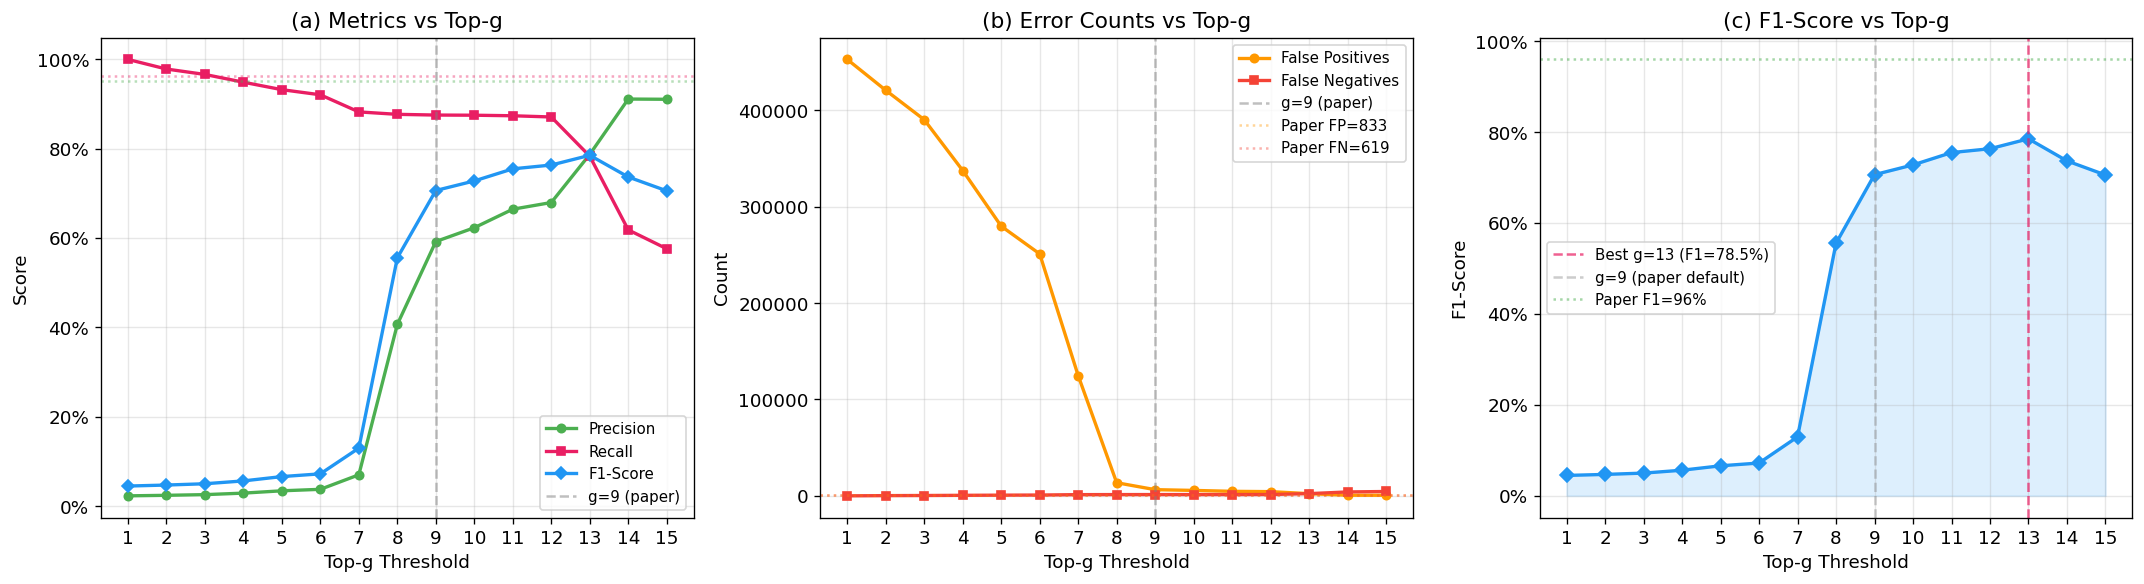

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Precision / Recall / F1 vs g
ax = axes[0]
ax.plot(df_g['g'], df_g['precision'], 'o-', color=COLORS['paper'], label='Precision', linewidth=2, markersize=5)
ax.plot(df_g['g'], df_g['recall'], 's-', color=COLORS['ours'], label='Recall', linewidth=2, markersize=5)
ax.plot(df_g['g'], df_g['f1'], 'D-', color=COLORS['train'], label='F1-Score', linewidth=2, markersize=5)
ax.axvline(9, color='gray', linestyle='--', alpha=0.5, label='g=9 (paper)')
ax.axhline(paper['precision'], color=COLORS['paper'], linestyle=':', alpha=0.4)
ax.axhline(paper['recall'], color=COLORS['ours'], linestyle=':', alpha=0.4)
ax.set_xlabel('Top-g Threshold')
ax.set_ylabel('Score')
ax.set_title('(a) Metrics vs Top-g')
ax.legend(fontsize=9)
ax.set_xticks(g_values)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# (b) FP / FN vs g
ax = axes[1]
ax.plot(df_g['g'], df_g['fp'], 'o-', color=COLORS['fp'], label='False Positives', linewidth=2, markersize=5)
ax.plot(df_g['g'], df_g['fn'], 's-', color=COLORS['fn'], label='False Negatives', linewidth=2, markersize=5)
ax.axvline(9, color='gray', linestyle='--', alpha=0.5, label='g=9 (paper)')
ax.axhline(paper['fp'], color=COLORS['fp'], linestyle=':', alpha=0.4, label=f'Paper FP={paper["fp"]}')
ax.axhline(paper['fn'], color=COLORS['fn'], linestyle=':', alpha=0.4, label=f'Paper FN={paper["fn"]}')
ax.set_xlabel('Top-g Threshold')
ax.set_ylabel('Count')
ax.set_title('(b) Error Counts vs Top-g')
ax.legend(fontsize=9)
ax.set_xticks(g_values)

# (c) F1 curve with best g highlighted
ax = axes[2]
best_g_idx = df_g['f1'].idxmax()
best_g = df_g.loc[best_g_idx, 'g']
best_f1 = df_g.loc[best_g_idx, 'f1']

ax.fill_between(df_g['g'], df_g['f1'], alpha=0.15, color=COLORS['train'])
ax.plot(df_g['g'], df_g['f1'], 'D-', color=COLORS['train'], linewidth=2, markersize=6)
ax.axvline(best_g, color=COLORS['ours'], linestyle='--', alpha=0.7,
           label=f'Best g={best_g} (F1={best_f1:.1%})')
ax.axvline(9, color='gray', linestyle='--', alpha=0.4, label='g=9 (paper default)')
ax.axhline(paper['f1'], color=COLORS['paper'], linestyle=':', alpha=0.5, label=f'Paper F1={paper["f1"]:.0%}')
ax.set_xlabel('Top-g Threshold')
ax.set_ylabel('F1-Score')
ax.set_title('(c) F1-Score vs Top-g')
ax.legend(fontsize=9)
ax.set_xticks(g_values)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

fig.tight_layout()
plt.show()

---
## 7. Sequence-Level Rank Distribution

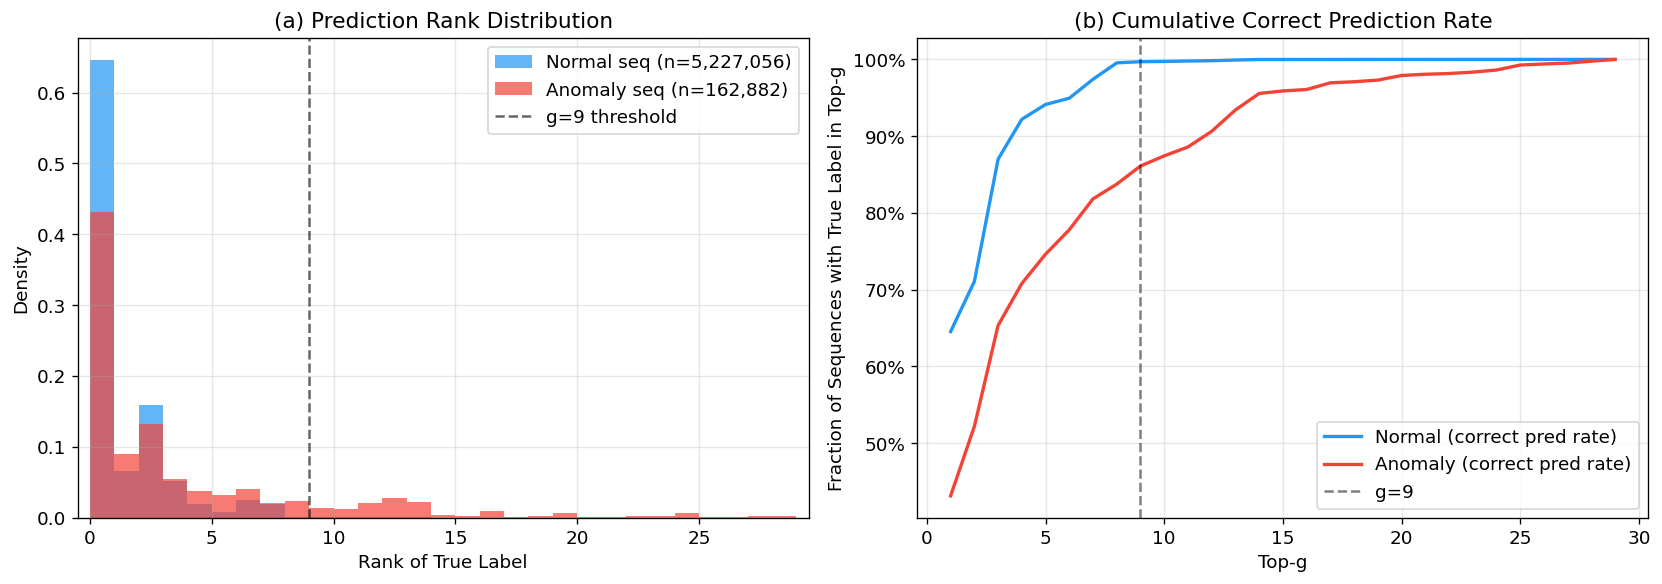


At g=9:
  Normal sequences correctly predicted:  99.7025%
  Anomaly sequences correctly predicted: 86.1139%
  Normal sequences flagged as anomaly:   0.2975% (15,551 sequences)


In [11]:
# Split ranks by session type
normal_ranks = all_ranks[np.array(all_session_labels) == 'Normal']
anomaly_ranks = all_ranks[np.array(all_session_labels) == 'Anomaly']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# (a) Rank histogram (all sequences)
ax = axes[0]
bins = np.arange(0, 30)
ax.hist(normal_ranks, bins=bins, alpha=0.7, color=COLORS['normal'],
        label=f'Normal seq (n={len(normal_ranks):,})', density=True)
ax.hist(anomaly_ranks, bins=bins, alpha=0.7, color=COLORS['anomaly'],
        label=f'Anomaly seq (n={len(anomaly_ranks):,})', density=True)
ax.axvline(9, color='black', linestyle='--', alpha=0.6, label='g=9 threshold')
ax.set_xlabel('Rank of True Label')
ax.set_ylabel('Density')
ax.set_title('(a) Prediction Rank Distribution')
ax.set_xlim(-0.5, 29.5)
ax.legend()

# (b) Cumulative: fraction of sequences with rank < g
ax = axes[1]
g_range = np.arange(1, 30)
normal_cdf = [np.mean(normal_ranks < g) for g in g_range]
anomaly_cdf = [np.mean(anomaly_ranks < g) for g in g_range]

ax.plot(g_range, normal_cdf, '-', color=COLORS['normal'], linewidth=2,
        label='Normal (correct pred rate)')
ax.plot(g_range, anomaly_cdf, '-', color=COLORS['anomaly'], linewidth=2,
        label='Anomaly (correct pred rate)')
ax.axvline(9, color='black', linestyle='--', alpha=0.5, label='g=9')
ax.set_xlabel('Top-g')
ax.set_ylabel('Fraction of Sequences with True Label in Top-g')
ax.set_title('(b) Cumulative Correct Prediction Rate')
ax.legend()
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

fig.tight_layout()
plt.show()

# Key stats
g = 9
normal_correct_rate = np.mean(normal_ranks < g)
anomaly_correct_rate = np.mean(anomaly_ranks < g)
print(f'\nAt g={g}:')
print(f'  Normal sequences correctly predicted:  {normal_correct_rate:.4%}')
print(f'  Anomaly sequences correctly predicted: {anomaly_correct_rate:.4%}')
print(f'  Normal sequences flagged as anomaly:   {1-normal_correct_rate:.4%} '
      f'({int((1-normal_correct_rate) * len(normal_ranks)):,} sequences)')

---
## 8. FP Source Analysis: Why Are Normal Sessions Flagged?

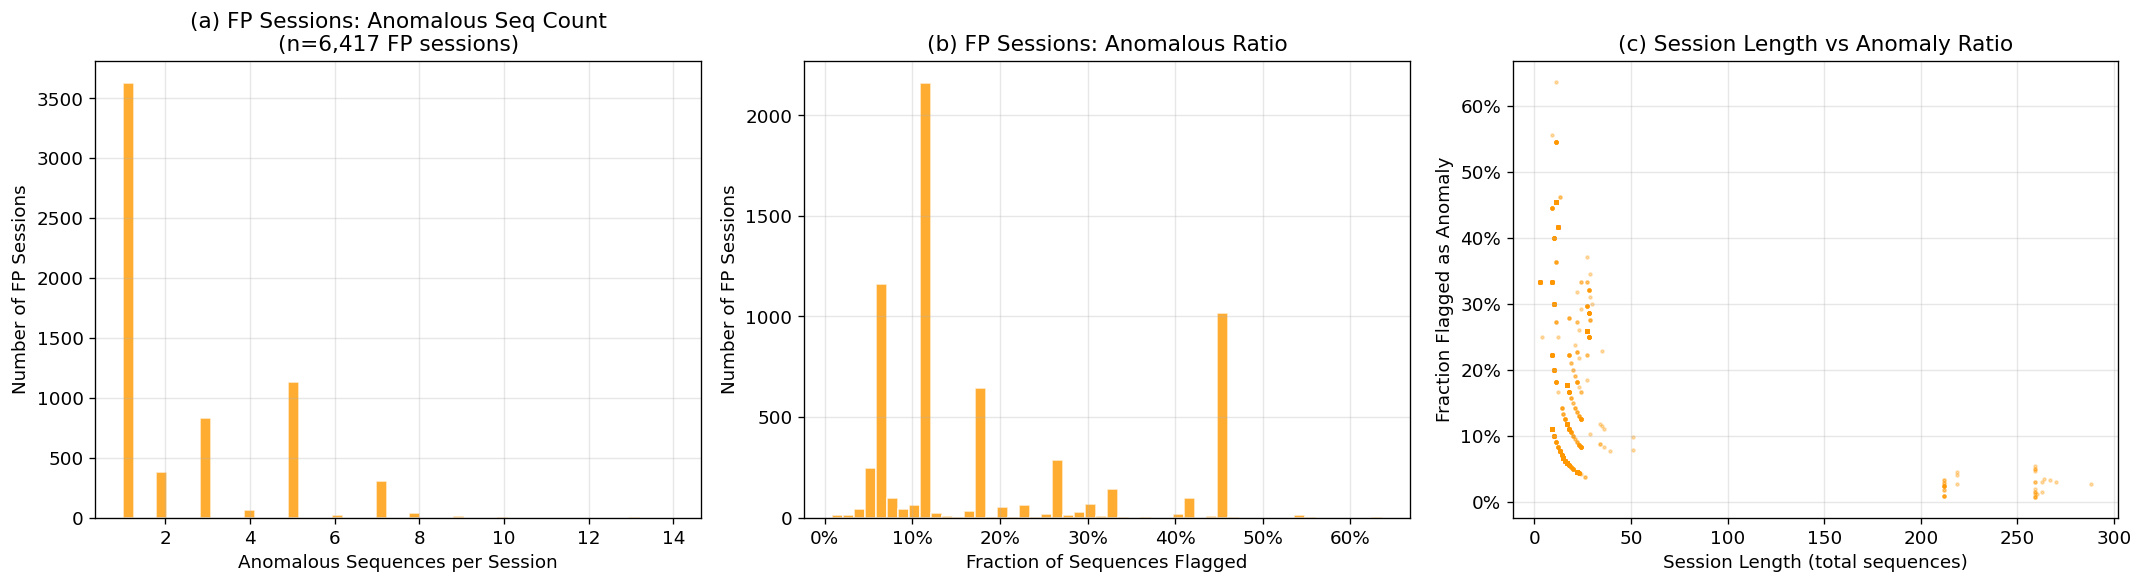

Total FP sessions: 6,417
FP sessions with only 1 anomalous sequence: 3,630 (56.6%)
FP sessions with <=2 anomalous sequences: 4,011 (62.5%)
Median anomalous seqs per FP session: 1
Mean anomalous ratio: 18.45%


In [12]:
# For each session, count how many of its sequences are flagged as anomaly
g = 9
session_anom_counts = defaultdict(int)
session_total_counts = defaultdict(int)

for idx in range(len(all_ranks)):
    bid = all_block_ids[idx]
    session_total_counts[bid] += 1
    if all_ranks[idx] >= g:
        session_anom_counts[bid] += 1

# Separate FP sessions (normal but predicted anomaly)
fp_sessions = []
for bid, gt in session_gt.items():
    if not gt and session_anom_counts.get(bid, 0) > 0:
        fp_sessions.append({
            'block_id': bid,
            'total_seqs': session_total_counts[bid],
            'anom_seqs': session_anom_counts[bid],
            'anom_ratio': session_anom_counts[bid] / session_total_counts[bid]
        })

df_fp = pd.DataFrame(fp_sessions)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# (a) Distribution of anomalous sequence count per FP session
ax = axes[0]
ax.hist(df_fp['anom_seqs'], bins=50, color=COLORS['fp'], alpha=0.8, edgecolor='white')
ax.set_xlabel('Anomalous Sequences per Session')
ax.set_ylabel('Number of FP Sessions')
ax.set_title(f'(a) FP Sessions: Anomalous Seq Count\n(n={len(df_fp):,} FP sessions)')

# (b) Anomalous ratio per FP session
ax = axes[1]
ax.hist(df_fp['anom_ratio'], bins=50, color=COLORS['fp'], alpha=0.8, edgecolor='white')
ax.set_xlabel('Fraction of Sequences Flagged')
ax.set_ylabel('Number of FP Sessions')
ax.set_title('(b) FP Sessions: Anomalous Ratio')
ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))

# (c) Session length vs anomalous ratio
ax = axes[2]
ax.scatter(df_fp['total_seqs'], df_fp['anom_ratio'], s=3, alpha=0.3, color=COLORS['fp'])
ax.set_xlabel('Session Length (total sequences)')
ax.set_ylabel('Fraction Flagged as Anomaly')
ax.set_title('(c) Session Length vs Anomaly Ratio')
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))

fig.tight_layout()
plt.show()

# Key stats
print(f'Total FP sessions: {len(df_fp):,}')
print(f'FP sessions with only 1 anomalous sequence: '
      f'{(df_fp["anom_seqs"] == 1).sum():,} ({(df_fp["anom_seqs"] == 1).mean():.1%})')
print(f'FP sessions with <=2 anomalous sequences: '
      f'{(df_fp["anom_seqs"] <= 2).sum():,} ({(df_fp["anom_seqs"] <= 2).mean():.1%})')
print(f'Median anomalous seqs per FP session: {df_fp["anom_seqs"].median():.0f}')
print(f'Mean anomalous ratio: {df_fp["anom_ratio"].mean():.2%}')

---
## 9. Results Summary

In [13]:
# Create a comprehensive summary
best_g_row = df_g.loc[df_g['f1'].idxmax()]
g9_row = df_g[df_g['g'] == 9].iloc[0]

summary = pd.DataFrame({
    'Metric': ['FP', 'FN', 'Precision', 'Recall', 'F1-Score'],
    'Paper (g=9)': [
        f"{paper['fp']:,}",
        f"{paper['fn']:,}",
        f"{paper['precision']:.1%}",
        f"{paper['recall']:.1%}",
        f"{paper['f1']:.1%}",
    ],
    f'Ours (g=9)': [
        f"{int(g9_row['fp']):,}",
        f"{int(g9_row['fn']):,}",
        f"{g9_row['precision']:.1%}",
        f"{g9_row['recall']:.1%}",
        f"{g9_row['f1']:.1%}",
    ],
    f'Ours (best g={int(best_g_row["g"])})': [
        f"{int(best_g_row['fp']):,}",
        f"{int(best_g_row['fn']):,}",
        f"{best_g_row['precision']:.1%}",
        f"{best_g_row['recall']:.1%}",
        f"{best_g_row['f1']:.1%}",
    ],
})

print('=' * 70)
print('DeepLog HDFS Reproduction - Final Results Summary')
print('=' * 70)
print(summary.to_string(index=False))
print('=' * 70)
print(f'\nModel: 2-layer LSTM, hidden_size=64, embedding_dim=64')
print(f'Training: {train_sessions:,} normal sessions, {len(train_data["sequences"]):,} sequences')
print(f'Testing:  {len(session_gt):,} sessions ({test_normal:,} normal, {test_anomaly:,} anomaly)')
print(f'Best model epoch: {best_epoch} (val loss: {min(val_losses):.4f})')

DeepLog HDFS Reproduction - Final Results Summary
   Metric Paper (g=9) Ours (g=9) Ours (best g=13)
       FP         833      6,417            2,252
       FN         619      1,326            2,307
Precision       95.1%      59.2%            78.7%
   Recall       96.4%      87.5%            78.3%
 F1-Score       96.0%      70.7%            78.5%

Model: 2-layer LSTM, hidden_size=64, embedding_dim=64
Training: 4,855 normal sessions, 78,093 sequences
Testing:  564,015 sessions (553,368 normal, 10,647 anomaly)
Best model epoch: 33 (val loss: 0.1799)
